In [9]:
import os
import math
import time
import argparse
from tqdm import tqdm

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as ls
import torch.utils.data as d
from AttributeClassifier import AttributeClassifier, AttributeClassifierMobileNet
from LargeScaleAttributesDataset import LargeScaleAttributesDataset
from torchvision import transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from scheduler import GradualWarmupScheduler
import pickle
import utils as u
import matplotlib.pyplot as plt

In [2]:
dataset_root = '../../data/largescale/'
image_input_size = 299
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
test = pickle.load( open(  os.path.join(dataset_root,"test.pkl"), "rb" ) )
test.transform = transforms.Compose([ transforms.CenterCrop(image_input_size), transforms.ToTensor(), normalize ])

In [3]:
device = torch.device('cuda')
xception_model = AttributeClassifier(out_features=337, device=device)

final_checkpoint = torch.load('../trained_models/final_model.chkpt')
xception_model.load_state_dict(final_checkpoint['model'])
xception_model.eval()
print('Loaded')

Loaded


In [76]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = torch.sum(scores)    
    loss.backward()
    saliency = torch.max(X.grad.abs(), dim=1)[0]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

In [6]:
for param in xception_model.parameters():
    xception_model.requires_grad = False

tensor([1], device='cuda:0')


(-0.5, 298.5, 298.5, -0.5)

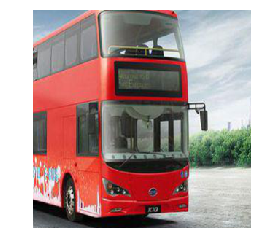

In [181]:
test.transform = transforms.Compose([ transforms.CenterCrop(image_input_size), transforms.ToTensor(), normalize ])
image = test[20]['image'].to(device)
y = torch.Tensor([1]).long().to(device)
print(y)
saliency = compute_saliency_maps(image.unsqueeze(0), y, xception_model)
image = image.permute(1,2,0)
image = (((image + 1) / 2.0) * 256 ).round().clamp(0, 255)

plt.imshow(image.detach().to('cpu').numpy().astype(np.uint8))
plt.axis('off')

In [182]:
import matplotlib
matplotlib.image.imsave('./saliency_bus_original', image.detach().to('cpu').numpy().astype(np.uint8))

(-0.5, 298.5, 298.5, -0.5)

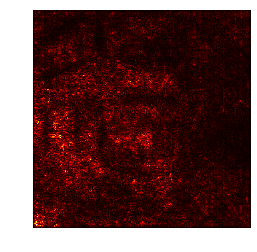

In [183]:
plt.imshow(saliency.cpu().squeeze(0), cmap=plt.cm.hot)
plt.axis('off')

In [167]:
matplotlib.image.imsave('./saliency_fruit', saliency.cpu().squeeze(0))